# `contextily`

In [25]:
%matplotlib inline

import contextily as ctx
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Data
from pysal.examples import get_path

## Download tiles

## Save tiles into raster files

## Read raster tiles and combine with vector data

* Vector polygons with `geopandas`

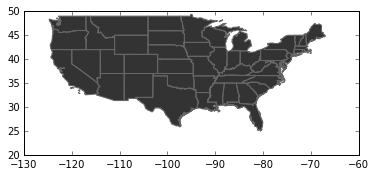

In [22]:
us = gpd.read_file(get_path('us48.shp'))
us.crs = {'init': 'epsg:4326'}
us.plot(facecolor='0.2', edgecolor='0.4', alpha=1);

* Raster with `rasterio`

In [57]:
rtr = rio.open('test.tif')

img = np.array([ band for band in rtr.read() ]).transpose(1, 2, 0)

## Combine layers

* Full extent

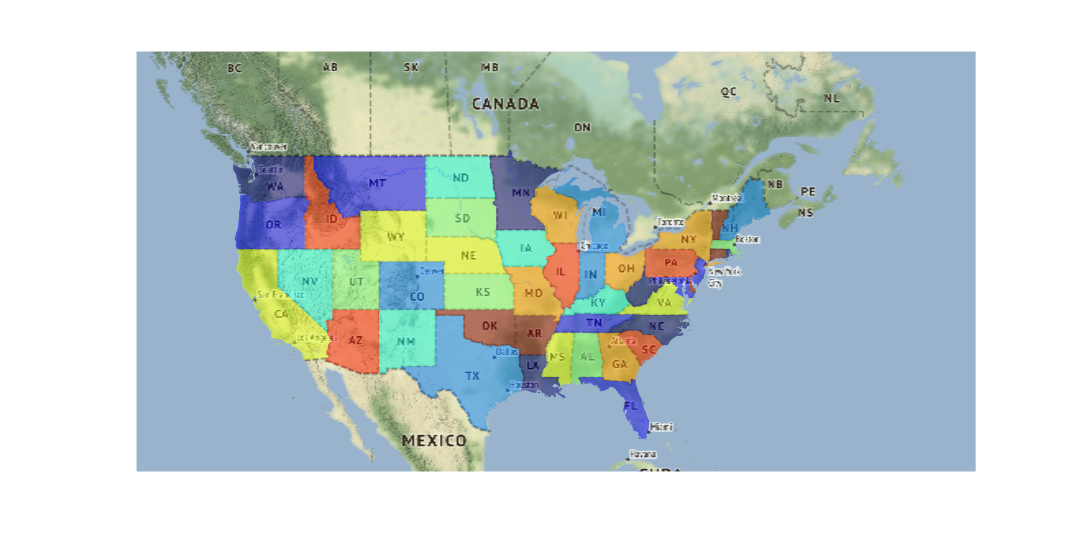

In [63]:
f, ax = plt.subplots(1, figsize=(18, 18))
bb = rtr.bounds
ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top))
us.to_crs(rtr.crs).plot(edgecolor='none', ax=ax)
ax.set_axis_off()
plt.show()

* Window

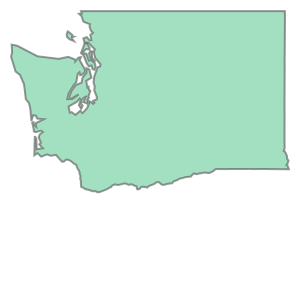

In [74]:
wa = us.set_index('STATE_ABBR').loc[['WA'], 'geometry'].to_crs(rtr.crs)
wa['WA']

* Pull out the window

In [90]:
# WA bounding box
bb = wa.bounds.values.flatten()
# Window
wdw = ctx.ll2wdw(bb, rtr)
# Raster subset
sub = np.array([ rtr.read(band, window=wdw) \
      for band in range(1, rtr.count+1)]).transpose(1, 2, 0)

* Plot

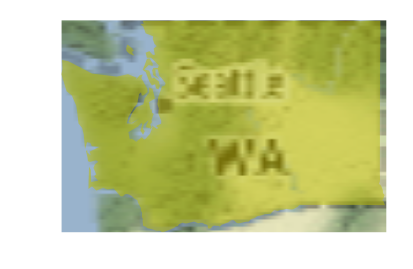

In [92]:
f, ax = plt.subplots(1, figsize=(6, 6))
ax.imshow(sub, extent=(bb[0], bb[2], bb[1], bb[3]))
wa.plot(facecolor='y', edgecolor='none', ax=ax)
ax.set_axis_off()
plt.show()